In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages
library(dplyr)
library(ggplot2)
library(corrplot)
library(openxlsx)
library(dplyr)
library(modeest)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
corrplot 0.92 loaded

Registered S3 method overwritten by 'rmutil':
  method         from
  print.response httr



[1] "heart-disease-dataset"

In [2]:
df <- read.csv("/kaggle/input/heart-disease-dataset/heart_disease.csv")
head(df)
dim(df)

,Gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,Heart_.stroke
,<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>
1,Male,39,postgraduate,0,0,0,no,0,0,195,106.0,70,26.97,80,77,No
2,Female,46,primaryschool,0,0,0,no,0,0,250,121.0,81,28.73,95,76,No
3,Male,48,uneducated,1,20,0,no,0,0,245,127.5,80,25.34,75,70,No
4,Female,61,graduate,1,30,0,no,1,0,225,150.0,95,28.58,65,103,yes
5,Female,46,graduate,1,23,0,no,0,0,285,130.0,84,23.10,85,85,No
6,Female,43,primaryschool,0,0,0,no,1,0,228,180.0,110,30.30,77,99,No


[1] 4238   16

In [3]:
# removed duplicated rows
df <- df %>% 
  distinct()
dim(df)

[1] 4238   16

In [4]:
#change col name
names(df)[names(df) == "Heart_.stroke"] <- "Stroke"
#covert to factor
df$Gender <- factor(df$Gender)
df$education <- factor(df$education)
df$prevalentStroke <- factor(df$prevalentStroke)
df$Stroke <- factor(df$Stroke)

In [5]:
# look for missing values
missing_values <- colSums(is.na(df))
print(missing_values[missing_values > 0])

 education cigsPerDay     BPMeds    totChol        BMI  heartRate    glucose 
       105         29         53         50         19          1        388 


In [6]:
# numerical imputation
df <- df %>%
  mutate(across(where(is.numeric), ~ifelse(is.na(.), median(., na.rm = TRUE), .)))

In [7]:
# mode imputation
get_mode <- function(x) {
  mode_result <- mlv(x, method = "mfv")
  return(mode_result[[1]])
}

mode_category <- get_mode(df$education)
df$education[is.na(df$education)] <- mode_category

In [8]:
# check missing values check again
sum(is.na(df))

[1] 0

In [9]:
head(df[,c(5,10:15)])

mahal <-  mahalanobis(df[ , c(5,10:15)], 
                      colMeans(df[ , c(5,10:15)], 
                               na.rm = TRUE), 
                      cov(df[ , c(5,10:15)], 
                          use = "pairwise.complete.obs"))
cutoff <-  qchisq(0.999, ncol(df[ , c(5,10:15)]))
summary(mahal < cutoff)

,cigsPerDay,totChol,sysBP,diaBP,BMI,heartRate,glucose
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,0,195,106.0,70,26.97,80,77
2,0,250,121.0,81,28.73,95,76
3,20,245,127.5,80,25.34,75,70
4,30,225,150.0,95,28.58,65,103
5,23,285,130.0,84,23.10,85,85
6,0,228,180.0,110,30.30,77,99


   Mode   FALSE    TRUE 
logical     100    4138 

In [10]:
data_nooutlier <- subset(df, mahal < cutoff) # removes the outliers from scores
nrow(data_nooutlier)

df <- data_nooutlier # "df" is the pre-processed dataset (final to be used)
dim(df)

[1] 4138

[1] 4138   16

In [11]:
# convert categories to numeric for model building
df$Gender <- ifelse(df$Gender == "Male", 1, 0)
df$education <- as.numeric(df$education)
df$prevalentStroke <- ifelse(df$prevalentStroke == "yes", 1, 0)
df$Stroke <- ifelse(df$Stroke == "yes", 1, 0)

df$Gender <- as.numeric(df$Gender)
df$education <- as.numeric(df$education)
df$prevalentStroke <- as.numeric(df$prevalentStroke)
df$Stroke <- as.numeric(df$Stroke)

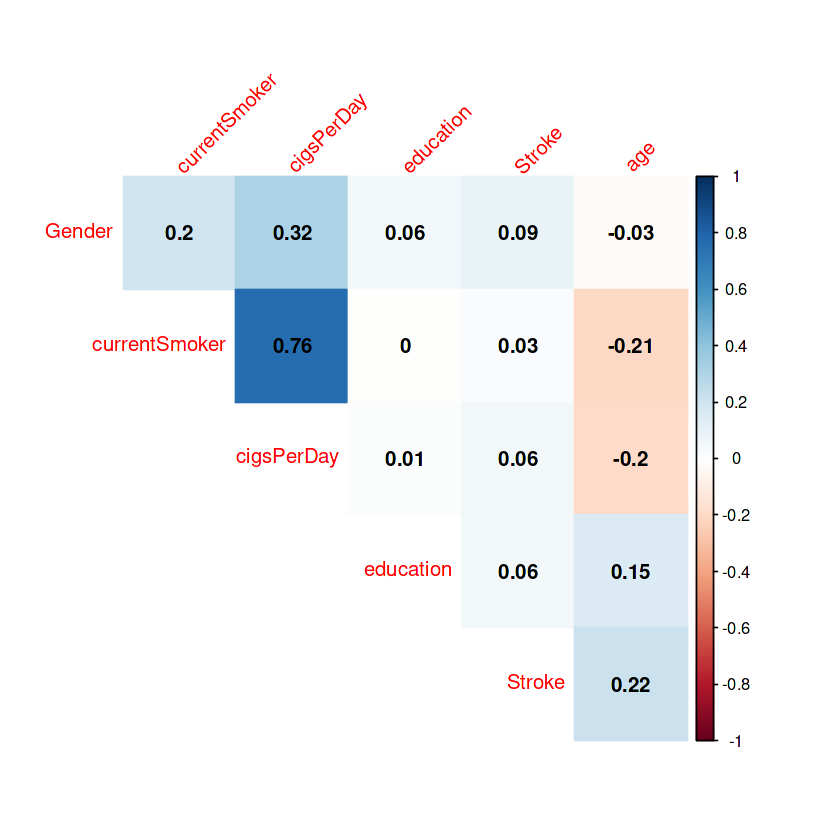

In [12]:
#Demographic and Clinical Variables:
demo_clinical <- df[,c("Stroke","Gender","age","education","currentSmoker","cigsPerDay")]
corrplot(cor(demo_clinical),
         addCoef.col = "black" ,
         method = "color", 
         type = "upper",diag = F,
         order = "hclust",
         tl.srt = 45)

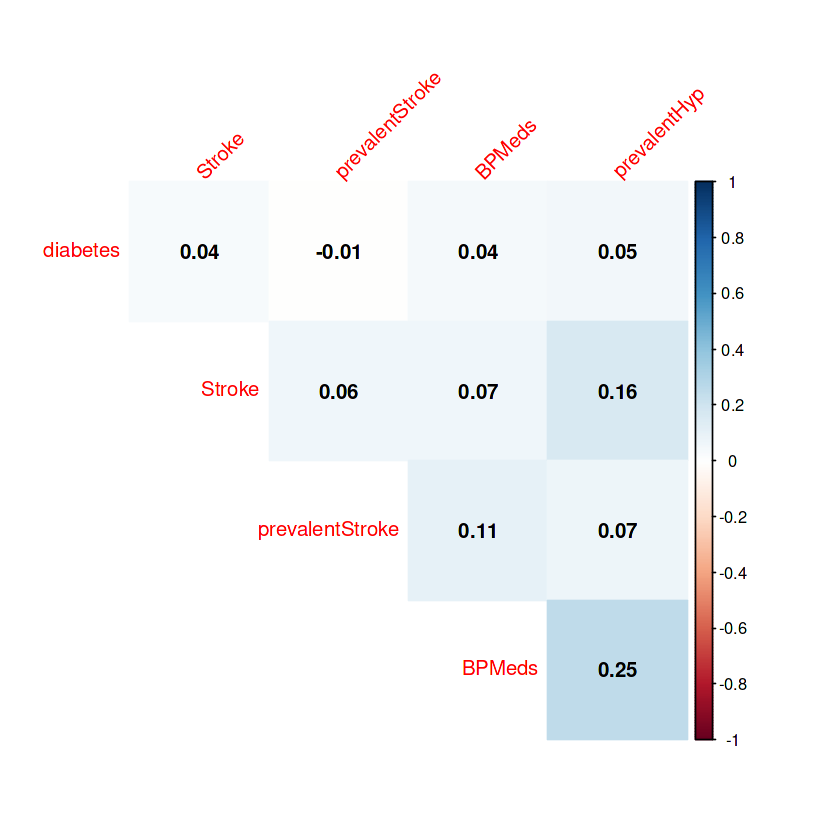

In [13]:
#Symptoms and Medical History:
bp <- df[,c("Stroke","BPMeds","prevalentStroke","prevalentHyp","diabetes")]
corrplot(cor(bp),
         addCoef.col = "black" ,
         method = "color", 
         type = "upper",diag = F,
         order = "hclust",
         tl.srt = 45)


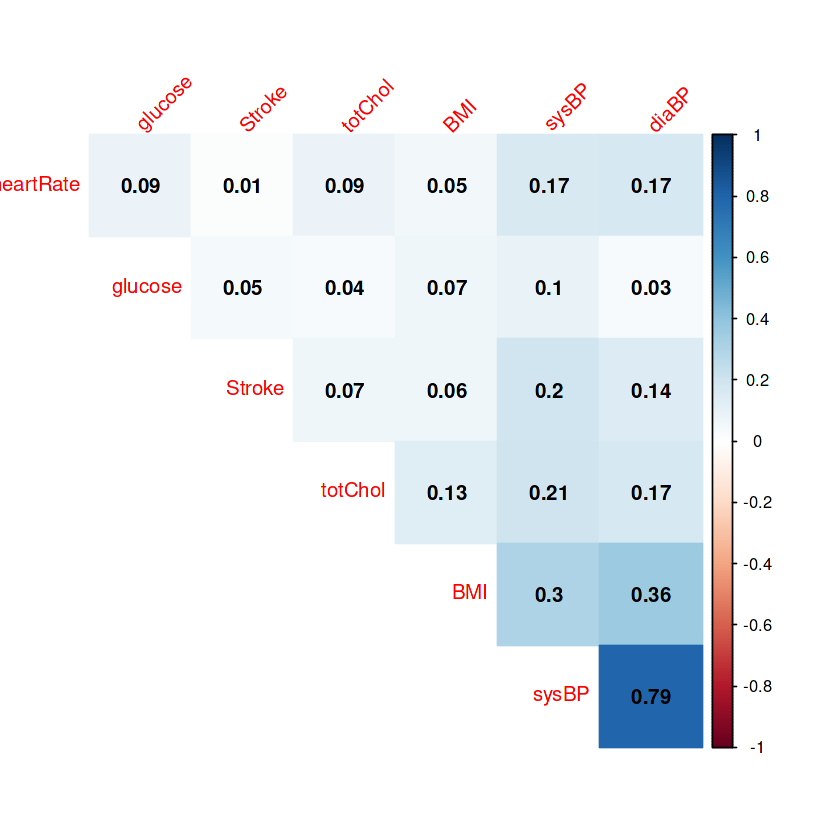

In [14]:
#Diagnostic Procedures and Results:
med <- df[,c("Stroke","totChol" ,"sysBP", "diaBP","BMI", "heartRate","glucose")]
corrplot(cor(med),
         addCoef.col = "black" ,
         method = "color", 
         type = "upper",diag = F,
         order = "hclust",
         tl.srt = 45)

In [15]:
#Model Building
dataset = df[, c("Gender",
                      "age",
                      "cigsPerDay",
                      "BPMeds",
                      "prevalentStroke",
                      "diabetes",
                      "totChol",
                      "sysBP",
                      "heartRate",
                      "Stroke")]


# Step 2: Splitting the data into the Training set and Test set
library(caTools)
set.seed(123)
split = sample.split(dataset$Stroke, SplitRatio = 0.75)
training_set = subset(dataset, split == TRUE)
test_set = subset(dataset, split == FALSE)

# Step 3: Feature Scaling
training_set[-10] = scale(training_set[-10])
test_set[-10] = scale(test_set[-10])

# Step 4: Fitting Logistic Regression to the Training set
classifier = glm(formula = Stroke ~ .,
                 family = binomial,
                 data = training_set)
summary(classifier)



Call:
glm(formula = Stroke ~ ., family = binomial, data = training_set)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4369  -0.5885  -0.4284  -0.2814   2.8836  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -2.044632   0.062944 -32.483  < 2e-16 ***
Gender           0.307466   0.058366   5.268 1.38e-07 ***
age              0.545383   0.061072   8.930  < 2e-16 ***
cigsPerDay       0.264362   0.054434   4.857 1.19e-06 ***
BPMeds           0.006231   0.045477   0.137   0.8910    
prevalentStroke  0.089971   0.039799   2.261   0.0238 *  
diabetes         0.040073   0.044515   0.900   0.3680    
totChol          0.101288   0.055719   1.818   0.0691 .  
sysBP            0.372263   0.055284   6.734 1.65e-11 ***
heartRate       -0.006574   0.054764  -0.120   0.9044    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2562.0  on 3102

In [16]:
# Step 5: Predicting the Test set results
prob_pred = predict(classifier, type = 'response', newdata = test_set[-10])
y_pred = ifelse(prob_pred > 0.5, 1, 0)

# Step 6: Making the Confusion Matrix
cm = table(test_set[, 10], y_pred > 0.5)
cm

   
    FALSE TRUE
  0   882    3
  1   141    9

In [17]:
confusion_matrix <- matrix(cm, ncol = 2, byrow = F)
confusion_matrix
accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
print(paste("Accuracy of the Logistic Regression Model:", accuracy))

882,3
141,9


[1] "Accuracy of the Logistic Regression Model: 0.860869565217391"


`geom_smooth()` using formula = 'y ~ x'


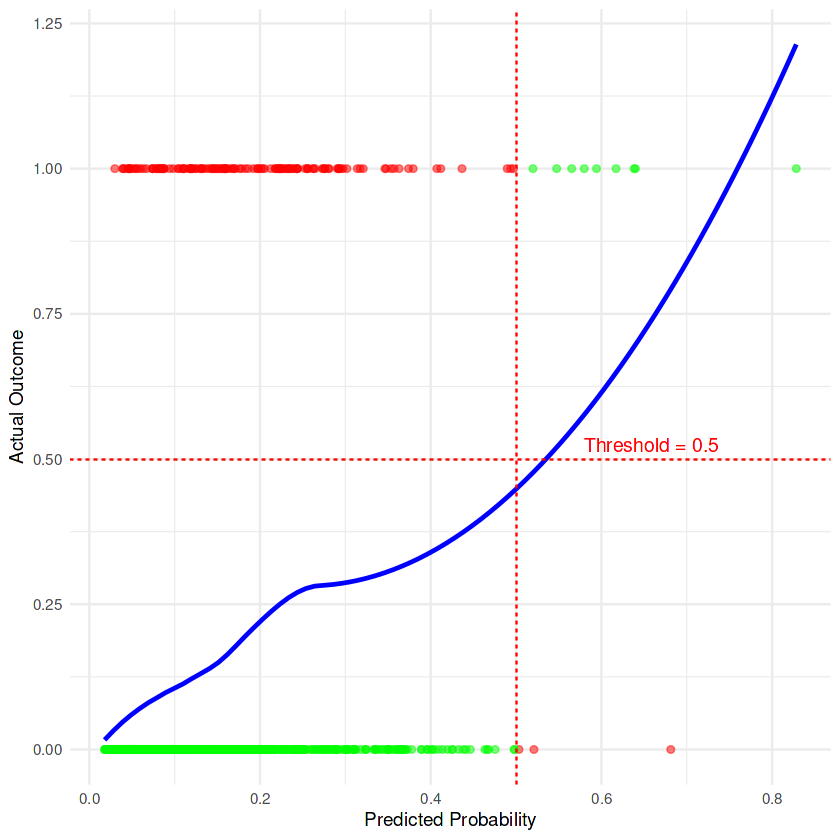

In [18]:
plot_data <- data.frame(Predicted = prob_pred,
                        Observed = test_set$Stroke)

plot_data$color <- ifelse(plot_data$Predicted < 0.5 & plot_data$Observed < 0.5, "green",
                          ifelse(plot_data$Predicted > 0.5 & plot_data$Observed == 1.00, "green", "red"))


ggplot(plot_data, aes(x = Predicted, y = Observed, color = color)) +
  geom_point(alpha = 0.5) +
  geom_smooth(method = "loess", se = F, color = "blue") +
  geom_vline(xintercept = 0.5, linetype = "dashed", color = "red") +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "red") +
  annotate("text", x = 0.5, y = 0.5, label = "Threshold = 0.5", color = "red", size = 4, hjust = -0.5, vjust = -0.5) +
  labs(x = "Predicted Probability", y = "Actual Outcome") +
  scale_color_identity() +
  theme_minimal()